In [1]:
import pysam as ps
import numpy as np
import collections
import matplotlib.pyplot as plt
from numpy.core.defchararray import array, center
import pysam as ps
import numpy as np
from collections import defaultdict
from scipy.ndimage.measurements import label, standard_deviation
from scipy.stats.mstats_basic import kstest, normaltest
from sklearn.cluster import KMeans
import sys
from scipy.signal import savgol_filter
import math
from subprocess import call
import os.path
from utils import Gene, TSS, Point
from scipy import stats
from sklearn import svm
import sympy
import math
from math import e
import random
from keras import Model
from keras.models import load_model
import numpy as np
import os
import pandas as pd

2021-11-30 22:47:39.193228: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-30 22:47:39.193287: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
dic = {
    'gene':'./data/gene/GRCh37.gene.bed',
    'non_gene':'./data/gene/non_gene.bed',
    'non_gene_4':'./data/gene/non_gene_4.bed',
    'non_gene_2':'./data/gene/non_gene_2.bed',
    'fasta':'/home/jiay/Desktop/hg19/hg19.fa',
    'bam1':'./data/051.bam',
    'bam2':'./data/051_2.bam',
    'bam3':'./data/051_3.bam',
    'bam123':'./data/051_123.bam',
    'bam4':'./data/051_4.bam',
    'bam5':'./data/051_5.bam',
    'TSS_low':'./data/gene/low_expressed.bed',
    'TSS_HK':'./data/gene/HK.bed',
    'TSS_silent':'./data/gene/silent_gene_TSS.bed',
    'ATAC_hema_1':'./data/gene/ATAC_hema_1.bed',
    'ATAC_hema_2':'./data/gene/ATAC_hema_2.bed',
    'ATAC_Bcell':'./data/gene/ATAC_Bcell.bed',
    'ATAC_Bcell':'./data/gene/ATAC_Bcell.bed',
    'ATAC_Brain':'./data/gene/ATAC_Brain.bed'
    }
TSS_HK = []
# with open(dic['TSS_HK'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         if ll[0] in ['1','2','3']:
#             TSS_HK.append(TSS(ll[0], int(int(ll[1])+1000)))
with open(dic['ATAC_hema_1'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        TSS_HK.append(TSS(ll[0], int((int(ll[1])+int(ll[2]))/2)))
        


TSS_NonGene = []
with open(dic['non_gene'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        TSS_NonGene.append(TSS(ll[0], int(ll[1])+int(1000)))
# with open(dic['ATAC_Bcell'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         if ll[0] in ['1','2','3'] and ll[2] == '0':
#             TSS_NonGene.append(TSS(ll[0],int(ll[1])))

bamfile = ps.AlignmentFile(dic['bam123'],'rb')

TSS_NonGene = TSS_NonGene[:len(TSS_HK)]

TSSes_x = TSS_HK + TSS_NonGene
TSSes_y = [1]*len(TSS_HK) + [0]*len(TSS_NonGene)
perm = random.sample(range(len(TSSes_x)),len(TSSes_x))
TSSes_x = np.array(TSSes_x)
TSSes_y = np.array(TSSes_y)
TSSes_x = TSSes_x[perm[:len(perm)]]
TSSes_y = TSSes_y[perm[:len(perm)]]
labels = TSSes_y
up = 1000
down = 1000

In [3]:
#lstm
feature_matrix = []
for j, tss in enumerate(TSSes_x):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
    up_end = np.zeros(up+down, dtype= int)
    down_end = np.zeros(up+down, dtype= int)
    long = np.zeros(up+down, dtype= int)
    short = np.zeros(up+down, dtype= int)
    cov = np.zeros(up+down, dtype= int)
    wps = np.zeros(up+down, dtype=float)
    win = 120
    for r in bamfile.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            ss = r.reference_start - start
            ee = r.reference_start - start + abs(r.isize)
            if ss >= 0:
                up_end[ss] += 1
            else:
                ss = 0
            if ee < end - start:
                down_end[ee] += 1
            else:
                ee = end - start
            for i in range(ss, ee):
                cov[i] += 1
            if 200 >= abs(r.isize) > 130:
                for i in range(ss, ee):
                    long[i] += 1
            if abs(r.isize) <= 130:
                for i in range(ss, ee):
                    short[i] += 1
            # wps_total
            region1 = int(max(0, ss + win/2))
            region2 = int(min(ee - win/2, end-start))
            i = region1
            while i < region2:
                wps[i] += 1
                i = i+1
            # wps_part
            region1 = int(max(0, ss - win/2))
            region2 = int(min(end-start, ss + win/2))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i + 1
            # wps_part
            region1 = int(max(ee - win/2, 0))
            region2 = int(min(ee + win/2, end-start))
            i = region1
            while i < region2:
                wps[i] -= 1
                i = i+1
    k = 0
    win = 40
    feature_win = np.zeros((int((up+down)/win), 4), dtype= int)
    while k < (up+down)/win:
        ss = k * win
        ee = k * win + win
        ff = []
        ff.append(int(round(np.mean(cov[ss:ee]))))
        ff.append(int(round(np.mean(long[ss:ee]-short[ss:ee]))))
        ff.append(int(round(np.sum(abs(up_end[ss:ee]-down_end[ss:ee])))))
        ff.append(int(round(np.mean(wps[ss:ee]))))
        feature_win[k] = np.array(ff)
        k = k + 1
    feature_matrix.append(feature_win)
feature_matrix = np.array(feature_matrix)

lstm_x = []
for mat in feature_matrix:
    lstm_x.append(mat)
lstm_x = np.array(lstm_x)


In [28]:
'''cnn_input'''
raw_data = []
for j, tss in enumerate(TSSes_x):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
#    distribution_matrix = np.zeros((int(up+down), 200), dtype=int)
    distribution_matrix = np.zeros((200,200),dtype=int)
    for r in bamfile.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse and 50 < abs(r.isize) < 250:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            if r.reference_start < start:
                continue
            if r.reference_start + abs(r.isize) > end:
                continue
            ss = max(0, r.reference_start - start)
            relative_isize = abs(r.isize)-50
            distribution_matrix[ss//10,relative_isize] += 1
    raw_data.append(distribution_matrix)
raw_data = np.array(raw_data)

cnn_x = []
for mat in raw_data:
    cnn_x.append(mat)
cnn_x = np.array(cnn_x)

In [29]:
train_cnn_x = cnn_x[:int(len(cnn_x)*0.8)]
train_lstm_x = lstm_x[:int(len(lstm_x)*0.8)]
train_y = labels[:int(len(labels)*0.8)]
test_cnn_x = cnn_x[int(len(cnn_x)*0.8):]
test_lstm_x = lstm_x[int(len(lstm_x)*0.8):]
test_y = labels[int(len(labels)*0.8):]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import layers
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
def attention_3d_block(inputs):
    a = layers.Permute((2, 1))(inputs)
    a = layers.Dense(50, activation='softmax')(a)
    a_probs = layers.Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = layers.multiply([inputs, a_probs], name='attention_mul')
    return output_attention_mul
def get_attention_model(cnn_x, lstm_x):
    cnn_input = layers.Input(shape=(cnn_x.shape[1],cnn_x.shape[2]), name='cnn_input')
    conv1 = layers.Convolution1D(filters=32, kernel_size=2, strides=2, activation='relu', padding='same')(cnn_input)
    cnn_output = layers.AveragePooling1D(pool_size=2, strides=2)(conv1)
    flatten = layers.Flatten()(cnn_output)
    # flatten = Dense(3, activation='relu', name='inner-output')(flatten)
    aux_output = layers.Dense(1, activation='sigmoid', name='aux_output')(flatten)
    aux_input = layers.Input(shape=(lstm_x.shape[1], lstm_x.shape[2]), name='aux_input')
    x = layers.concatenate([cnn_output, aux_input])
    x = aux_input
    lstm_out = layers.Bidirectional(LSTM(50, return_sequences=True),name='0')(x)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = layers.Flatten()(attention_mul)
    # attention_mul = Dense(3, activation='relu', name='inner_output2')(attention_mul)
    main_output = layers.Dense(1, activation='sigmoid', kernel_regularizer=None, bias_regularizer=None,name='6')(attention_mul)
    model = Model(inputs=[cnn_input, aux_input], outputs=[main_output, aux_output])
    # model = Model(inputs=aux_input, outputs=main_output)
    return model
model = get_attention_model(cnn_x,lstm_x)
# model.summary()
adam = keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# history = model.fit(train_lstm_x, train_y, epochs=300, batch_size=128, validation_split=0.1,callbacks=[EarlyStopping(patience=10), ModelCheckpoint(filepath='./conv_lstm.h5', save_best_only=True)],
#                         shuffle=True, verbose=2)
history = model.fit([cnn_x, lstm_x], [labels, labels], epochs=300, batch_size=128, validation_split=0.1,callbacks=[EarlyStopping(patience=10), ModelCheckpoint(filepath='./conv_lstm.h5', save_best_only=True)],
                        shuffle=True, verbose=2)

In [ ]:
from keras.layers import Input, Embedding, LSTM, Dense, concatenate, Convolution1D, MaxPooling1D, Flatten, Bidirectional,Dropout, AveragePooling1D
from keras.models import Model
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

cnn_input = Input(shape=(cnn_x.shape[1],cnn_x.shape[2]), name='cnn_input')
conv1 = Convolution1D(filters=32, kernel_size=2, strides=2, activation='relu', padding='same')(cnn_input)
cnn_output = AveragePooling1D(pool_size=2, strides=2)(conv1)
# conv2 = Convolution1D(filters=16, kernel_size=2, strides=2, activation='relu', padding='same')(cnn_output)
# cnn_output = MaxPooling1D(pool_size=2, strides=2)(conv2)
flatten = Flatten()(cnn_output)
# flatten = Dense(2, activation='relu', name='inner_output')(flatten)
aux_output = Dense(1, activation='sigmoid', name='aux_output')(flatten)

aux_input = Input(shape=(lstm_x.shape[1], lstm_x.shape[2]), name='aux_input')
x = concatenate([cnn_output, aux_input])

lstm_out = Bidirectional(LSTM(50, return_sequences=True),name='0')(x)
conv = Convolution1D(filters=100, kernel_size=3, activation='relu',strides=1,padding='same',name='1')(lstm_out)
pool = MaxPooling1D(pool_size=2, strides=2,name='2')(conv)
drop = Dropout(0.2)(pool)
flatten = Flatten()(drop)
dense = Dense(300, activation='relu', kernel_regularizer=None, bias_regularizer=None,name='4')(flatten)
drop = Dropout(0.2)(dense)
# drop = Dense(3, activation='relu', kernel_regularizer=None, bias_regularizer=None,name='inner_output2')(drop)
main_output = Dense(1, activation='sigmoid', kernel_regularizer=None, bias_regularizer=None,name='6')(drop)

model = Model(inputs=[cnn_input, aux_input], outputs=[main_output, aux_output])

# print(model.summary())
adam = keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit([cnn_x, lstm_x], [labels, labels], epochs=300, batch_size=128, validation_split=0.1,callbacks=[EarlyStopping(patience=10), ModelCheckpoint(filepath='./conv_lstm.h5', save_best_only=True)],
                        shuffle=True, verbose=2)

In [30]:
pre = model.predict([cnn_x,lstm_x])[0]
count = 0
for i,p in enumerate(pre):
    if p < 0.5 and labels[i] == 0:
        count += 1
    elif p >= 0.5 and labels[i] == 1:
        count += 1
    # elif p < 0.5 and labels[i] == 1:
    #     error_1.append(i)
    # else:
    #     error_0.append(i)
print(count/len(cnn_x))

0.9693708609271523


In [94]:
pre = Model(inputs = model.input, outputs=model.get_layer('inner_output2').output).predict(test_lstm_x)

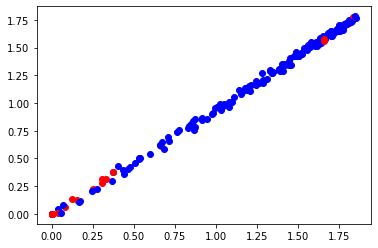

166 162


In [96]:
c1= 0
c2 = 0
for i in range(len(test_y)):
    if test_y[i] == 1:
        plt.scatter(pre[i][0],pre[i][1],color='r')
        c1+=1
    else:   
        # if pre[i][0] > 9:
        #     continue
        plt.scatter(pre[i][0],pre[i][1],color='b')
        c2+=1
plt.show()
print(c1,c2)

/tmp/ipykernel_11251/1812524752.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


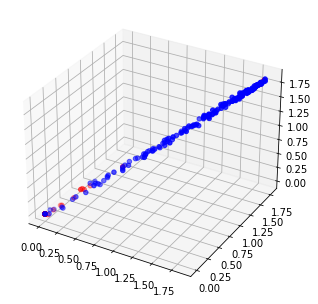

In [95]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
x_1 = []
y_1 = []
z_1 = []
x_0 = []
y_0 = []
z_0 = []
for i in range(len(test_y)):
    if test_y[i] == 1:
        x_1.append(pre[i][0])
        y_1.append(pre[i][1])
        z_1.append(pre[i][2])
        # l1.append(pre[i])
        # plt.scatter(pre[i][0],pre[i][1],color='r')
    else:
        if pre[i][2]>5:
            continue
        x_0.append(pre[i][0])
        y_0.append(pre[i][1])
        z_0.append(pre[i][2])        
        # l2.append(pre[i])
        # if pre[i][1] > 35:
        #     continue
        # plt.scatter(pre[i][0],pre[i][1],color='b')
# plt.show()
ax.scatter(x_1,y_1,z_1,color='r')
ax.scatter(x_0,y_0,z_0,color='b')
plt.show()




In [61]:
print(len(cnn_x))

232


In [30]:
from keras.layers import Input, Embedding, LSTM, Dense, concatenate, Convolution1D, MaxPooling1D, Flatten, Bidirectional,Dropout, AveragePooling1D
from keras.models import Model
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

cnn_input = Input(shape=(cnn_x.shape[1], cnn_x.shape[2]), name='cnn_input')
lstm_input = Input(shape=(lstm_x.shape[1], lstm_x.shape[2]), name='lstm_input')
x = Convolution1D(filters=64, kernel_size=2, strides=2, activation='relu', padding='same',name='conv1')(cnn_input)
x = AveragePooling1D(pool_size=2, strides=2)(x)
# conv1 = Convolution1D(filters=32, kernel_size=2, strides=2, activation='relu', padding='same',name='conv2')(conv1)
cnn_output = Model(inputs=cnn_input, outputs=x)

main_input = concatenate([cnn_output.output, lstm_input])

lstm_out = Bidirectional(LSTM(50, return_sequences=True),name='0')(main_input)
x = Convolution1D(filters=100, kernel_size=3, activation='relu',strides=1,padding='same',name='1')(lstm_out)
x = MaxPooling1D(pool_size=2, strides=2,name='2')(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(300, activation='relu', kernel_regularizer=None, bias_regularizer=None)(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu', kernel_regularizer=None, bias_regularizer=None)(x)
x = Dropout(0.2)(x)
x = Dense(2, activation='sigmoid', kernel_regularizer=None, bias_regularizer=None,name='4')(x)
main_output = Dense(1, activation='sigmoid', kernel_regularizer=None, bias_regularizer=None,name='6')(x)

model = Model(inputs=[cnn_input, lstm_input], outputs=main_output)

adam = keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit([train_cnn_x, train_lstm_x], train_y, epochs=300, batch_size=128, validation_split=0.1,callbacks=[EarlyStopping(patience=10), ModelCheckpoint(filepath='./conv_1.h5', save_best_only=True)],
                        shuffle=True, verbose=2)
loss, accuracy = model.evaluate([test_cnn_x,test_lstm_x], test_y)
print("loss=",loss,"acc=",accuracy)

/home/jiay/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/300
16/16 - 4s - loss: 0.6805 - accuracy: 0.5737 - val_loss: 0.6324 - val_accuracy: 0.7330
Epoch 2/300
16/16 - 1s - loss: 0.6140 - accuracy: 0.7611 - val_loss: 0.5559 - val_accuracy: 0.8326
Epoch 3/300
16/16 - 1s - loss: 0.5567 - accuracy: 0.8157 - val_loss: 0.5142 - val_accuracy: 0.8326
Epoch 4/300
16/16 - 1s - loss: 0.5221 - accuracy: 0.8354 - val_loss: 0.4926 - val_accuracy: 0.8462
Epoch 5/300
16/16 - 1s - loss: 0.5067 - accuracy: 0.8470 - val_loss: 0.4798 - val_accuracy: 0.8462
Epoch 6/300
16/16 - 1s - loss: 0.4908 - accuracy: 0.8520 - val_loss: 0.4731 - val_accuracy: 0.8416
Epoch 7/300
16/16 - 1s - loss: 0.4822 - accuracy: 0.8631 - val_loss: 0.4665 - val_accuracy: 0.8416
Epoch 8/300
16/16 - 1s - loss: 0.4672 - accuracy: 0.8722 - val_loss: 0.4604 - val_accuracy: 0.8552
Epoch 9/300
16/16 - 1s - loss: 0.4728 - accuracy: 0.8566 - val_loss: 0.4596 - val_accuracy: 0.8507
Epoch 10/300
16/16 - 1s - loss: 0.4685 - accuracy: 0.8657 - val_loss: 0.4603 - val_accuracy: 0.8507
Epoch 11/

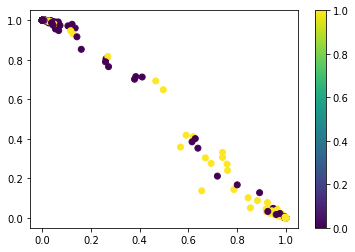

111 92


In [31]:
pre = Model(inputs = model.input, outputs=model.get_layer('4').output).predict([cnn_x, lstm_x])
plt.scatter(pre[:, 0], pre[:, 1], c=labels)
# plt.colorbar()
plt.show()
c_1 = []
c_0 = []
for i,p in enumerate(pre):
    if labels[i] == 1 and p[0] < 0.2:
        c_0.append(i)
    elif labels[i] == 0 and p[0] > 0.2:
        c_1.append(i)
print(len(c_0),len(c_1))

In [ ]:
from keras.layers import Input, Embedding, LSTM, Dense, concatenate, Convolution1D, MaxPooling1D, Flatten, Bidirectional,Dropout, AveragePooling1D
from keras.models import Model
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
LL = keras.utils.to_categorical(labels)
''''''
cnn_input = Input(shape=(cnn_x.shape[1], cnn_x.shape[2]), name='cnn_input')
lstm_input = Input(shape=(lstm_x.shape[1], lstm_x.shape[2]), name='lstm_input')
conv1 = Convolution1D(filters=32, kernel_size=2, strides=2, activation='relu', padding='same')(cnn_input)
pool1 = AveragePooling1D(pool_size=2, strides=2)(conv1)
cnn_output = Model(inputs=cnn_input, outputs=pool1)
main_input = concatenate([cnn_output.output, lstm_input])
lstm_out = Bidirectional(LSTM(50, return_sequences=True),name='0')(main_input)
conv = Convolution1D(filters=100, kernel_size=3, activation='relu',strides=1,padding='same',name='1')(lstm_out)
pool = MaxPooling1D(pool_size=2, strides=2,name='2')(conv)
drop = Dropout(0.2)(pool)
flatten = Flatten()(drop)
dense = Dense(300, activation='relu', kernel_regularizer=None, bias_regularizer=None,name='4')(flatten)
drop = Dropout(0.2)(dense)
main_output = Dense(2, activation='softmax', kernel_regularizer=None, bias_regularizer=None,name='6')(drop)
''''''
model = Model(inputs=[cnn_output.input, lstm_input], outputs=main_output)

adam = keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit([cnn_x, lstm_x], LL, epochs=300, batch_size=128, validation_split=0.1,callbacks=[EarlyStopping(patience=10), ModelCheckpoint(filepath='./conv_lstm.h5', save_best_only=True)],
                        shuffle=True, verbose=2)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import layers
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
LL = keras.utils.to_categorical(labels)
def attention_3d_block(inputs):
    a = Permute((2, 1))(inputs)
    a = Dense(50, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = layers.multiply([inputs, a_probs], name='attention_mul')
    return output_attention_mul
def get_attention_model(cnn_x, lstm_x):
    cnn_input = Input(shape=(cnn_x.shape[1], cnn_x.shape[2]), name='cnn_input')
    lstm_input = Input(shape=(lstm_x.shape[1], lstm_x.shape[2]), name='lstm_input')
    conv1 = Convolution1D(filters=32, kernel_size=2, strides=2, activation='relu', padding='same')(cnn_input)
    pool1 = AveragePooling1D(pool_size=2, strides=2)(conv1)
    cnn_output = Model(inputs=cnn_input, outputs=pool1)
    main_input = concatenate([cnn_output.output, lstm_input])

    lstm_out = Bidirectional(LSTM(50, return_sequences=True),name='0')(main_input)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    main_output = Dense(1, activation='sigmoid', kernel_regularizer=None, bias_regularizer=None,name='6')(attention_mul)
    model = Model(inputs=[cnn_output.input, lstm_input], outputs=main_output)
    return model
model = get_attention_model(cnn_x,lstm_x)
adam = keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit([cnn_x, lstm_x], labels, epochs=300, batch_size=128, validation_split=0.1,callbacks=[EarlyStopping(patience=10), ModelCheckpoint(filepath='./conv_lstm.h5', save_best_only=True)],
                        shuffle=True, verbose=2)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import layers
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
def attention_3d_block(inputs):
    a = Permute((2, 1))(inputs)
    a = Dense(50, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = layers.multiply([inputs, a_probs], name='attention_mul')
    return output_attention_mul
def get_attention_model(cnn_x, lstm_x):
    cnn_input = Input(shape=(cnn_x.shape[1], cnn_x.shape[2]), name='cnn_input')
    lstm_input = Input(shape=(lstm_x.shape[1], lstm_x.shape[2]), name='lstm_input')
    conv1 = Convolution1D(filters=32, kernel_size=2, strides=2, activation='relu', padding='same')(cnn_input)
    pool1 = AveragePooling1D(pool_size=2, strides=2)(conv1)
    cnn_output = Model(inputs=cnn_input, outputs=pool1)
    main_input = concatenate([cnn_output.output, lstm_input])

    lstm_out = Bidirectional(LSTM(50, return_sequences=True),name='0')(main_input)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    main_output = Dense(2, activation='softmax', kernel_regularizer=None, bias_regularizer=None,name='6')(attention_mul)
    model = Model(inputs=[cnn_output.input, lstm_input], outputs=main_output)
    return model
model = get_attention_model(cnn_x,lstm_x)
adam = keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit([cnn_x, lstm_x], LL, epochs=300, batch_size=128, validation_split=0.1,callbacks=[EarlyStopping(patience=10), ModelCheckpoint(filepath='./conv_lstm.h5', save_best_only=True)],
                        shuffle=True, verbose=2)

In [51]:
def focal_loss(y_true, y_pred):
   gamma = 2.0
   alpha = 0.5
   pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
   pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
   return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K


model = keras.Sequential()
model.add(keras.layers.Bidirectional(keras.layers.LSTM(50, return_sequences=True),input_shape=(lstm_x.shape[1], lstm_x.shape[2])))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(300, activation='relu', kernel_regularizer=None, bias_regularizer=None))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=None, bias_regularizer=None))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(2, activation='sigmoid', kernel_regularizer=None, bias_regularizer=None,name='4'))
model.add(keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=None, bias_regularizer=None))

# print(model.summary())

adam = keras.optimizers.Adam(lr=1e-4)
# model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=adam, loss=focal_loss, metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(train_lstm_x, train_y, epochs=300, batch_size=128, validation_split=0.1,
                        callbacks=[EarlyStopping(patience=10), ModelCheckpoint(filepath='./' + 'lstm_0.h5', save_best_only=True)],
                        shuffle=True, verbose=2)
loss, accuracy = model.evaluate(test_lstm_x, test_y)
print("loss=",loss,'acc=',accuracy)

Epoch 1/300
16/16 - 4s - loss: 10.0885 - accuracy: 0.6929 - val_loss: 8.1002 - val_accuracy: 0.8507
Epoch 2/300
16/16 - 1s - loss: 8.5602 - accuracy: 0.8040 - val_loss: 7.3131 - val_accuracy: 0.8507
Epoch 3/300
16/16 - 1s - loss: 7.9612 - accuracy: 0.8328 - val_loss: 7.1493 - val_accuracy: 0.8235
Epoch 4/300
16/16 - 1s - loss: 7.5867 - accuracy: 0.8500 - val_loss: 7.0737 - val_accuracy: 0.8371
Epoch 5/300
16/16 - 1s - loss: 7.4406 - accuracy: 0.8535 - val_loss: 6.9638 - val_accuracy: 0.8371
Epoch 6/300
16/16 - 1s - loss: 7.3522 - accuracy: 0.8621 - val_loss: 6.8846 - val_accuracy: 0.8416
Epoch 7/300
16/16 - 1s - loss: 7.1999 - accuracy: 0.8677 - val_loss: 6.8234 - val_accuracy: 0.8416
Epoch 8/300
16/16 - 1s - loss: 7.1993 - accuracy: 0.8747 - val_loss: 6.7867 - val_accuracy: 0.8507
Epoch 9/300
16/16 - 1s - loss: 7.1167 - accuracy: 0.8753 - val_loss: 6.7298 - val_accuracy: 0.8643
Epoch 10/300
16/16 - 1s - loss: 7.0503 - accuracy: 0.8737 - val_loss: 6.6499 - val_accuracy: 0.8552
Epoch 11

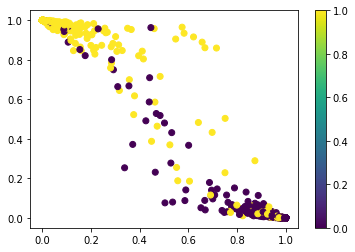

In [50]:
pre = Model(inputs = model.input, outputs=model.get_layer('4').output).predict(lstm_x)
plt.scatter(pre[:, 0], pre[:, 1], c=labels)
plt.colorbar()
plt.show()
c_1 = []
c_0 = []
for i,p in enumerate(pre):
    if labels[i] == 1 and p[0] < 0.2:
        c_0.append(i)
    elif labels[i] == 0 and p[0] > 0.2:
        c_1.append(i)

11/11 [==============================] - 0s 7ms/step - loss: 0.0890 - accuracy: 0.9756


In [29]:
from keras.layers import Input, Embedding, LSTM, Dense, concatenate, Convolution1D, MaxPooling1D, Flatten, Bidirectional,Dropout, AveragePooling1D
from keras.models import Model
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

cnn_input = Input(shape=(cnn_x.shape[1], cnn_x.shape[2]), name='cnn_input')
lstm_input = Input(shape=(lstm_x.shape[1], lstm_x.shape[2]), name='lstm_input')
conv1 = Convolution1D(filters=64, kernel_size=2, strides=2, activation='relu', padding='same',name='conv1')(cnn_input)
conv1 = AveragePooling1D(pool_size=2, strides=2)(conv1)
# conv1 = Convolution1D(filters=32, kernel_size=2, strides=2, activation='relu', padding='same',name='conv2')(conv1)
cnn_output = Model(inputs=cnn_input, outputs=conv1)
main_input = concatenate([cnn_output.output, lstm_input])

lstm_out = Bidirectional(LSTM(50, return_sequences=True),name='0')(main_input)
conv = Convolution1D(filters=100, kernel_size=3, activation='relu',strides=1,padding='same',name='1')(lstm_out)
pool = MaxPooling1D(pool_size=2, strides=2,name='2')(conv)
drop = Dropout(0.2)(pool)
flatten = Flatten()(drop)
dense = Dense(300, activation='relu', kernel_regularizer=None, bias_regularizer=None,name='4')(flatten)
drop = Dropout(0.2)(dense)
# dense = Dense(16, activation='relu', kernel_regularizer=None, bias_regularizer=None,name='4')(flatten)
# drop = Dropout(0.2)(dense)
main_output = Dense(1, activation='sigmoid', kernel_regularizer=None, bias_regularizer=None,name='6')(drop)

model = Model(inputs=[cnn_output.input, lstm_input], outputs=main_output)

adam = keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit([cnn_x, lstm_x], labels, epochs=300, batch_size=128, validation_split=0.1,callbacks=[EarlyStopping(patience=10), ModelCheckpoint(filepath='./conv_.h5', save_best_only=True)],
                        shuffle=True, verbose=2)



/home/jiay/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/300
12/12 - 4s - loss: 0.5479 - accuracy: 0.7632 - val_loss: 0.3794 - val_accuracy: 0.9207
Epoch 2/300
12/12 - 1s - loss: 0.3244 - accuracy: 0.8833 - val_loss: 0.2691 - val_accuracy: 0.9146
Epoch 3/300
12/12 - 1s - loss: 0.2596 - accuracy: 0.9071 - val_loss: 0.2352 - val_accuracy: 0.9390
Epoch 4/300
12/12 - 1s - loss: 0.2357 - accuracy: 0.9179 - val_loss: 0.2335 - val_accuracy: 0.9390
Epoch 5/300
12/12 - 1s - loss: 0.2289 - accuracy: 0.9145 - val_loss: 0.1997 - val_accuracy: 0.9451
Epoch 6/300
12/12 - 1s - loss: 0.2138 - accuracy: 0.9247 - val_loss: 0.1955 - val_accuracy: 0.9573
Epoch 7/300
12/12 - 1s - loss: 0.2039 - accuracy: 0.9274 - val_loss: 0.1910 - val_accuracy: 0.9573
Epoch 8/300
12/12 - 1s - loss: 0.1997 - accuracy: 0.9288 - val_loss: 0.1942 - val_accuracy: 0.9512
Epoch 9/300
12/12 - 1s - loss: 0.1927 - accuracy: 0.9342 - val_loss: 0.1899 - val_accuracy: 0.9573
Epoch 10/300
12/12 - 1s - loss: 0.1801 - accuracy: 0.9369 - val_loss: 0.1857 - val_accuracy: 0.9573
Epoch 11/

In [40]:
from keras.layers import Input, Embedding, LSTM, Dense, concatenate, Convolution1D, MaxPooling1D, Flatten, Bidirectional,Dropout, AveragePooling1D
from keras.models import Model
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

cnn_input = Input(shape=(cnn_x.shape[1], cnn_x.shape[2]), name='cnn_input')
# lstm_input = Input(shape=(lstm_x.shape[1], lstm_x.shape[2]), name='lstm_input')
conv1 = Convolution1D(filters=64, kernel_size=2, strides=1, activation='relu', padding='same',name='conv1')(cnn_input)
conv1 = AveragePooling1D(pool_size=2, strides=2)(conv1)
conv1 = Dropout(0.2)(conv1)
conv1 = Convolution1D(filters=64, kernel_size=5, strides=1, activation='relu', padding='same',name='conv1')(cnn_input)
conv1 = AveragePooling1D(pool_size=2, strides=2)(conv1)
conv1 = Dropout(0.2)(conv1)
# conv1 = Convolution1D(filters=32, kernel_size=2, strides=2, activation='relu', padding='same',name='conv2')(conv1)
# cnn_output = Model(inputs=cnn_input, outputs=conv1)
# main_input = concatenate([cnn_output.output, lstm_input])

lstm_out = Bidirectional(LSTM(50, return_sequences=True),name='0')(conv1)
conv1 = Convolution1D(filters=100, kernel_size=3, activation='relu',strides=1,padding='same',name='1')(conv1)
pool = MaxPooling1D(pool_size=2, strides=2,name='2')(conv1)
drop = Dropout(0.2)(pool)
flatten = Flatten()(drop)
dense = Dense(300, activation='relu', kernel_regularizer=None, bias_regularizer=None,name='4')(flatten)
drop = Dropout(0.2)(dense)
# dense = Dense(16, activation='relu', kernel_regularizer=None, bias_regularizer=None,name='4')(flatten)
# drop = Dropout(0.2)(dense)
main_output = Dense(1, activation='sigmoid', kernel_regularizer=None, bias_regularizer=None,name='6')(drop)

model = Model(inputs=cnn_input, outputs=main_output)

adam = keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(cnn_x, labels, epochs=300, batch_size=128, validation_split=0.1,callbacks=[EarlyStopping(patience=10), ModelCheckpoint(filepath='./cnn_2.h5', save_best_only=True)],
                        shuffle=True, verbose=2)


/home/jiay/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/300
12/12 - 2s - loss: 0.6786 - accuracy: 0.5081 - val_loss: 0.6680 - val_accuracy: 0.4878
Epoch 2/300
12/12 - 1s - loss: 0.6480 - accuracy: 0.6296 - val_loss: 0.6360 - val_accuracy: 0.6341
Epoch 3/300
12/12 - 1s - loss: 0.6114 - accuracy: 0.6967 - val_loss: 0.5901 - val_accuracy: 0.8171
Epoch 4/300
12/12 - 1s - loss: 0.5655 - accuracy: 0.7938 - val_loss: 0.5359 - val_accuracy: 0.8232
Epoch 5/300
12/12 - 1s - loss: 0.5054 - accuracy: 0.8270 - val_loss: 0.4777 - val_accuracy: 0.8415
Epoch 6/300
12/12 - 1s - loss: 0.4495 - accuracy: 0.8406 - val_loss: 0.4220 - val_accuracy: 0.8537
Epoch 7/300
12/12 - 1s - loss: 0.4035 - accuracy: 0.8514 - val_loss: 0.3873 - val_accuracy: 0.8415
Epoch 8/300
12/12 - 1s - loss: 0.3603 - accuracy: 0.8731 - val_loss: 0.3438 - val_accuracy: 0.8780
Epoch 9/300
12/12 - 1s - loss: 0.3333 - accuracy: 0.8752 - val_loss: 0.3215 - val_accuracy: 0.8902
Epoch 10/300
12/12 - 1s - loss: 0.3072 - accuracy: 0.8915 - val_loss: 0.3291 - val_accuracy: 0.8841
Epoch 11/